In [2]:
import torch
from torch import nn
from torch import tensor
from matplotlib import pyplot as plt
import pandas as pd
from torch.nn import functional as f

from torchvision import datasets, transforms


In [3]:
mnist_data = datasets.MNIST(
    root='',
    train=True, 
    transform=transforms.ToTensor(), 
    download=True
)

In [4]:
print(mnist_data)
print('Size: ', len(mnist_data))

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()
Size:  60000


In [7]:
x_train = mnist_data.train_data
y_train = mnist_data.train_labels

x_test = mnist_data.test_data
y_test = mnist_data.test_labels

In [207]:
def reshape(x):
    squeezed = x.clone().detach()
    data_shape = squeezed.shape
    
    data_size = data_shape[0]
    squeezed.resize_(data_size, data_shape[1]*data_shape[2])     
        
    squeezed.request_grad = True
    
    return squeezed


def one_hot(y, classes=10):
    return f.one_hot(y, num_classes=classes)


def de_one_hot(y):
    return torch.argmax(y, dim=1)


def batch_partition(x, y, batch_size=10000):
    cache = {}
    batches_x = []
    batches_y = []
    
    set_size = x.shape[0]
    n = set_size // batch_size
    leftover = set_size % n
    
    
    for i in range(n):
        batches_x.append(x[i:batch_size*(i+1), :])
        batches_y.append(y[i:batch_size*(i+1), :])
    if leftover:
        batches_x.append(x[batch_size*n:, :])
        batches_y.append(y[batch_size*n:, :])
    
    cache['batch_x'] = batches_x
    cache['batch_y'] = batches_y
    cache['batch_num'] = n + (1 if leftover else 0)
    
    return cache 

In [208]:
x_train_squeezed = reshape(x_train).float()
x_test_squeezed = reshape(x_test).float()

y_train_onehot = one_hot(y_train).float()

batch_cache = batch_partition(x_train_squeezed, y_train_onehot)

In [213]:
class MnistDistinguish(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act1 = f.relu
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.act2 = nn.Softmax(dim=-1)
        
    def forward(self, x):
        out1 = self.act1(self.fc1(x))
        out2 = f.dropout(out1, training=self.training)
        out = self.act2(self.fc2(out2))
        
        return out
    
    
def create_model(input_size, hidden_size, output_size, learning_rate=0.05):
    cache = {}
    model = MnistDistinguish(input_size, hidden_size, output_size)
    cost = f.cross_entropy
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    cache['model'] = model
    cache['cost'] = cost
    cache['optimizer'] = optimizer
    
    return cache
    

def batch_training(model_cache, batch_cache, epochs=20):
    model = model_cache['model']
    cost = model_cache['cost']
    optimizer = model_cache['optimizer']
    
    batch_x = batch_cache['batch_x']
    batch_y = batch_cache['batch_y']
    batch_num = batch_cache['batch_num']
    
    for j in range(batch_num):
        x = batch_x[j]
        y = batch_y[j]
        for i in range(epochs):
            out = model(x)
            loss = cost(out, y)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            if not i % 20:
                print('batch ', j + 1, ' epoch ', i, ', loss: ', round(loss.item(), 4))
            

def testing(model, x, y):
    test_size = len(y)
    model.eval()
    with torch.no_grad():
        pred = de_one_hot(model(x))
        
        exact = torch.sum(torch.eq(pred, y)).item()
        exact_rate = exact / test_size
        
        return exact_rate
    
    
def recognizing(model, x):
    model.eval()
    with torch.no_grad():
        out = model.forward(x)
        value = torch.argmax(out).item()
    return value

In [214]:
model_cache = create_model(x_train_squeezed.shape[1], 128, 10)
batch_training(model_cache, batch_cache)

batch  1  epoch  0 , loss:  2.3569
batch  2  epoch  0 , loss:  1.7751
batch  3  epoch  0 , loss:  1.694
batch  4  epoch  0 , loss:  1.6439
batch  5  epoch  0 , loss:  1.6109
batch  6  epoch  0 , loss:  1.5956


In [215]:
testing(model_cache['model'], x_test_squeezed, y_test)

0.9200833333333334

y10 is  1


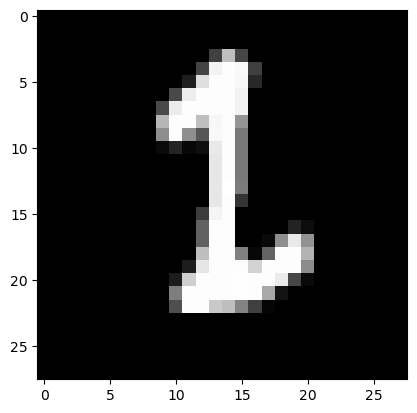

In [232]:
image = x_test[70]
data = x_test_squeezed[70]
print('y10 is ', y_test[70].item())

plt.imshow(image, cmap='gray')
plt.show()

In [234]:
recognizing(model_cache['model'], data)

2